# Ryan Gomberg - Quantitative Analysis Project
### May 16, 2025

We use the SQLite3 Package to import the dataset. Within the dataset, there are 4 categories, separated by tables:
1.  Constituents
2.  Price History
3.  Sqlite Sequence
4.  Price Target News

For this project, we will mainly be working with the Price History and Price Target News tables.

In [2]:
import sqlite3
import pandas as pd

con = sqlite3.connect("sp500_data.db")
tab = pd.read_sql("SELECT name FROM sqlite_master WHERE type = 'table';", con)
print("Tables", tab)

Tables                 name
0       constituents
1      price_history
2    sqlite_sequence
3  price_target_news


## Task 1: Mini-Factor Discovery

Goal: Identify a simple, publicly-observable equity factor that demonstrates predictive power for 
next-week returns in the S&P 500. 

For this task, we use the Price History Table and perform computations on the high, low, and close features.

In [3]:
OHLCV = pd.read_sql_query(f"SELECT * FROM {'price_history'}", con)
print(OHLCV)

            id symbol        date    open      high       low   close  \
0            1   DASH  2025-05-12  191.86  192.8299  185.9001  189.82   
1            2   DASH  2025-05-09  183.19  185.5900  180.5800  183.52   
2            3   DASH  2025-05-08  180.46  183.7500  178.3600  182.96   
3            4   DASH  2025-05-07  189.76  190.0900  175.5000  176.99   
4            5   DASH  2025-05-06  193.75  195.4200  185.2500  190.11   
...        ...    ...         ...     ...       ...       ...     ...   
626560  626561    XOM  2020-05-19   45.55   46.6300   43.9300   43.94   
626561  626562    XOM  2020-05-18   44.40   45.5800   44.0600   45.34   
626562  626563    XOM  2020-05-15   42.38   43.0100   41.8500   42.00   
626563  626564    XOM  2020-05-14   41.07   42.5500   40.2000   42.30   
626564  626565    XOM  2020-05-13   43.74   43.8700   41.6000   41.93   

        adj_close    volume  
0          189.82   1729212  
1          183.52   3421951  
2          182.96   4158800  
3  

### 5-Day Reversal Factor

Plainly, 5-Day Reversal Factor assess whether short-term mean reversal$-$stocks bouncing up or falling after going up/down for 5 days$-$is compatiable with a portfolio. For a set of daily closing prices, the 5-Day Reversal price is computed accordingly
$$R_t = - \left( \frac{\text{close}_{t - 1}}{\text{close}_{t - 6}} - 1 \right) $$

In [4]:
import numpy as np
from scipy.stats import ttest_1samp

OHLCV.sort_values(['symbol', 'date'])
OHLCV['returns'] = OHLCV.groupby('symbol')['close'].pct_change()
OHLCV['5 Day Returns'] = OHLCV.groupby('symbol')['returns'].rolling(5).sum().shift(1).reset_index(level = 0, drop = True)
OHLCV['5D Reversal'] = -1*OHLCV['5 Day Returns']

OHLCV['date'] = pd.to_datetime(OHLCV['date'])

OHLCV['week'] = OHLCV['date'].dt.to_period('W').apply(lambda w: w.start_time)
week = OHLCV.sort_values(['symbol', 'date']).groupby(['symbol', 'week']).last().reset_index()
week['rank'] = week.groupby('week')['5D Reversal'].transform(
    lambda x: pd.qcut(x, 5, labels = False, duplicates = 'drop') if x.nunique() >= 5 else pd.Series([np.nan] * len(x), index=x.index)
)

week['Next Week Returns'] = week.groupby('symbol')['returns'].shift(-1)

long = week[week['rank'] == 4]
short = week[week['rank'] == 0]

long_returns = long.groupby('week')['Next Week Returns'].mean()
short_returns = short.groupby('week')['Next Week Returns'].mean()

portfolio_returns = long_returns - short_returns

mean_returns = portfolio_returns.mean()
std_return = portfolio_returns.std()
t_stat = ttest_1samp(portfolio_returns.dropna(), 0).statistic
information_ratio = np.sqrt(252) * (mean_returns / std_return)

print(f"Mean Weekly Return: {mean_returns:.4f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"Information Ratio: {information_ratio:.2f}")

Mean Weekly Return: -0.0193
T-statistic: -20.17
Information Ratio: -19.85


### 3-Month Momentum

This equity factor aims to "ride the wave," or follow stocks that have performed well over the last 3 months to achieve short-term success. If we assume 3 months contains roughly 63 trading days and exclude the most recent day, then

$$M_t = \frac{\text{close}_{t - 1}}{\text{close}_{t - 63}} - 1.$$

In [13]:
OHLCV['3 Month Momentum'] = OHLCV.groupby('symbol')['close'].pct_change(periods = 63)
OHLCV['3 Month Momentum'] = OHLCV.groupby('symbol')['3 Month Momentum'].shift(1)

OHLCV['week'] = OHLCV['date'].dt.to_period('W').apply(lambda r: r.start_time)

OHLCV['Next Week Returns'] = OHLCV.groupby('symbol')['close'].pct_change(periods=5).shift(-5)

week = OHLCV.sort_values(['symbol', 'date']) \
              .groupby(['symbol', 'week']) \
              .last() \
              .reset_index()

OHLCV['rank_3m'] = week.groupby('week')['3 Month Momentum'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') if x.nunique() >= 5 else pd.Series([np.nan]*len(x), index=x.index)
)

long_returns_3m = OHLCV[OHLCV['rank_3m'] == 4].groupby('week')['Next Week Returns'].mean()
short_returns_3m = OHLCV[OHLCV['rank_3m'] == 0].groupby('week')['Next Week Returns'].mean()

portfolio_returns_3m = long_returns_3m - short_returns_3m

mean_returns_3m = portfolio_returns_3m.mean()
std_return_3m = portfolio_returns_3m.std()
t_stat_3m = ttest_1samp(portfolio_returns_3m.dropna(), 0).statistic
information_ratio_3m = np.sqrt(252) * (mean_returns_3m / std_return_3m)

print(f"Mean Weekly Return: {mean_returns_3m:.4f}")
print(f"T-statistic: {t_stat_3m:.2f}")
print(f"Information Ratio: {information_ratio_3m:.2f}")
print(week.columns)

Mean Weekly Return: -0.0007
T-statistic: -0.95
Information Ratio: -0.93
Index(['symbol', 'week', 'id', 'date', 'open', 'high', 'low', 'close',
       'adj_close', 'volume', 'returns', '5 Day Returns', '5D Reversal',
       '3 Month Momentum', 'Next Week Returns', 'Intraday Range',
       'Intraday Volatility', '5D Intraday Volatility', 'position'],
      dtype='object')


### Intraday Volatility

Intraday Volatility is a form of volatility that measures the *realized volatility* within a day. It aims to measure the (in)stability of a stock over a trading day.

$$IV_t = \frac{\text{high}_t - \text{low}_t}{\text{close}_t}$$

Larger gaps between high and low close prices are more likely to be riskier, as implied by the given formula.

In [16]:
OHLCV['Intraday Range'] = OHLCV['high'] - OHLCV['low']
OHLCV['Intraday Volatility'] = OHLCV['Intraday Range']/OHLCV['close']

OHLCV['5D Intraday Volatility'] = OHLCV.groupby('symbol')['Intraday Volatility'].rolling(5).mean().shift(1).reset_index(level=0, drop=True)

OHLCV['week'] = OHLCV['date'].dt.to_period('W').apply(lambda w: w.start_time)
week = OHLCV.sort_values(['symbol', 'date']).groupby(['symbol', 'week']).last().reset_index()

week['5 Day Intraday Vol'] = week.groupby('symbol')['5D Intraday Volatility'].transform('mean')

mean_volatility = week['5 Day Intraday Vol'].mean()
std_volatility = week['5 Day Intraday Vol'].std()

t_stat_volatility = ttest_1samp(week['5 Day Intraday Vol'].dropna(), 0).statistic

information_ratio_volatility = np.sqrt(252) * (mean_volatility / std_volatility)

print(f"Mean Weekly Intraday Volatility: {mean_volatility:.4f}")
print(f"T-statistic for Volatility: {t_stat_volatility:.2f}")
print(f"Information Ratio for Volatility: {information_ratio_volatility:.2f}")

Mean Weekly Intraday Volatility: 0.0250
T-statistic for Volatility: 1376.19
Information Ratio for Volatility: 60.43


### Which is the winning signal factor?

As alluded to, we are measuring each point-in-time factor based on *statistical robustness, economic reasoning,* and *ease of implementation.* After a thorough comparison between each, implementing a **3-month momentum** factor for measuring predictive power slightly outrivals the others, but none of them appear to actually be effective in our dataset.

1.  **Statistical Robustness**: Each of the three factors displays statistically significant results. However, mean returns and the information ratio for a 5-Day Reversal is negative, making it an unappealing choice and implies the portfolio is underperforming. A 3-month momentum portfolio suprisingly follows a similar return, but the results are unreliable given a small, negative t-statistic. Intraday Volatility method is more ambiguous in the sense that its metric is not the same as the other two (doesn't measure return). Although it has a large information ratio, it is not as interpretable and does not help evaluate future returns.
2.  **Economic Reasoning**: Despite a negative mean return for our *5-day reversal analysis*, that does not guarantee that the stocks will continue falling; In fact, it may bounce back. It is more difficult to price assets in short-term portfolios (especially in a 5-day analysis) and investors will lower the price of stock. However, the results show a general negative trend in the stock price with no expectation of a rebound, and is most likely not attributed to noise. 5-day reversals, in this portfolio, should be avoided for this reason -- it inclines us to long the unperforming stocks, which would backfire. *Intraday Volatility* is not ideal because, again, it emphasizes risk and not a stock's performance in the future, which in turn, does not forecast aggregate profit. A portfolio that uses *3-month momentum signals* is the most beneficial here; investors are prone to following consistent trends and react slowly to changes in stock price, especially if they are positive. Although it is a drawn-out process, 3-month momentum signals are safe if the underlying trend is a strictly increasing stock price, which unfortunately does not apply to our case.
3.  **Ease of Implementation**: Out of the 5 features (columns), 5-day reversal and 3-month momentum signals only require the daily closing price, whereas intraday volatility uses daily high, low, and closing prices. Usually all of this information will be available, but intraday volatility will require most of it and at high frequencies, making it a data-intensive signal and more computationally exhaustive compared to the other two, but we are able to making more meaningful conclusions (overall riskiness of an asset). 5-day reversal and 3-month momentum signals are easy to implement and only requires daily data of each asset. While mileage will vary depending on the portfolio, 5-day reversals are less likely to achieve reputable results as it is sensitive on noisy datasets.

With these considerations, I believe that while none of these signal factors should be used, a 3-month momentum signal would be the best (though not by much). It triumphs in economic foundation and implementation.

### Conclusion -- Task 1

Respectively, I chose 5-Day Reversal, 3-Month Momentum, and Intraday Volatility as candidate signal processes to test deviation from historical pricing, asset consistency, and short-term risk. For 5-Day Reversal, I was particularly shocked by the negative mean return of the signal given its statistical significance. For 3-Month Momentum, I was surprised by the statistical insignifiance of our results, and that the signal is more likely to be attributed to noise. For intraday volatility, I was impressed by the extremely high t-statistic. Rather than measuring returns, it can serve as a threshold for monitoring risky assets. If time allowed, I would try consolidating all 3 signal methods. More precisely, I would consider combining momentum and reversal methods to account for more dynamic situations (i.e. general upward trend with some small dips throughout). Momentum will counterbalance stocks that go against existing trends and Reversal signals will encourage investors to buy into these small dips when a stock is going strong. As for volatility, we could also look at an asset's implied volatility alongside intraday volatility to get a retrospective and prospective look on a market's risk and volatility, allowing us to identify unstable stocks.

## Task 2: Risk-Adjusted Back-tester in 30 Lines

Goal: Develop a concise and robust back-testing framework to evaluate the chosen factor strategy under realistic conditions, using the results from Task 1.

We impose the following assumptions before proceeding:
1.  Our portfolio is dollar-neutral, or insensitive to movements in the overall market. This is acheived by a weekly, cross-sectional ranking of momentum signals. We long the stocks in the top quintile (top 20%) and short the bottom quintile (bottom 20%).
2.  Using weekly signal rankings, portfolio "weights," or the contribution of a portfolio's value to each asset, are redistributed depending on whether stocks move in or out of the top and bottom quintiles. This ensures we are still market-neutral, for there are equally as many positive and negative weights.
3.  50 basis points, or a 0.5% fee, is required for entering and exiting long/short positions. 
4.  Risk Adjustment metrics are defined by Annualized Sharpe Ratio, Maximum Drawdowns, Turnovers, and a 52-week rolling Sharpe Ratio (more on these later).

Mathematically, we want to express each risk adjustment metric to better understand how each portfolio performs:

#### Long-Short Portfolio Return
Suppose $\overline{r}_t$ is the mean return of a portfolio over a given day $t$. Then, constructing a dollar-neutral portfolio $r_t^P$ is simply written as
$$r_t^P = \overline{r}_t^{Q_5} - \overline{r}_t^{Q_1}.$$
where $Q_5, Q_1$ are the top and bottom quintiles. If the bottom quintile is larger in magnitude, then we will expect a negative return.

#### Cumulative Returns
Let $t$ be the aggregate time of interest and $s$ be the number of days to be indexed. The cumulative return $\Pi_t$ is expressed as
$$\Pi_t = \prod_{s = 1}^t \left(1 + R_s^P \right).$$
$\Pi_t$ helps visualize the total performance over time (each week in our case). It is an exponential model and compounds depending on how an asset performs. More plainly, it is a growth multiplier. Ideally, $R_s^P > 0$ for all $s$, then we will undergo strict growth. 

#### Annualized Sharpe Ratio
For a given portfolio, the annualized Sharpe Ratio $S$ measures the risk-adjusted return of an investment (i.e. is the return on a portfolio worth the level of risk?). The computation requires us to use the mean portfolio $\mu$ and standard deviation of returns $\sigma$. Assuming 252 trading days (= 52 trading weeks) each year,
$$S = \sqrt{52} \cdot \frac{\mu}{\sigma}.$$
Where 
$$\mu = \frac{1}{t} \sum_{i = 1}^{T} R_i^P, \hspace{3mm} \sigma = \sqrt{\frac{1}{t - 1} \sum_{i = 1}^t \left(R_i^P - \mu \right)^2 }$$
are the mean portfolio and standard deviation of returns.

#### Rolling Sharpe Ratio
We wish to see how the Sharpe Ratio changes over each week. Let $\overrightarrow{R}_t = [R_1, \ldots, R_{52}]$ be a $1 \times 52$ vector containing the mean return over a rolling window, over a year, in weekly intervals. The **rolling Sharpe Ratio** in a given week $t$ is 

$$S_t = \frac{\overline{R}_t}{\sigma_t} = \frac{\frac{1}{52} \sum \overrightarrow{R}_i}{\sqrt{\frac{1}{51} \sum \left(\overrightarrow{R}_i - \overline{R}_t \right)^2 }} = \frac{\frac{1}{52} \sum_{i = 1}^{52} R_i }{\sqrt{\frac{1}{51} \sum_{i = 1}^{52} (R_i - \overline{R}_t )^2 }}$$

Typically $\overline{R}_t > \sigma_t$ implies good investment performance, depending on the magnitude of the ratio. To annualize the rolling Sharpe Ratio, again multiply by $\sqrt{52}$.

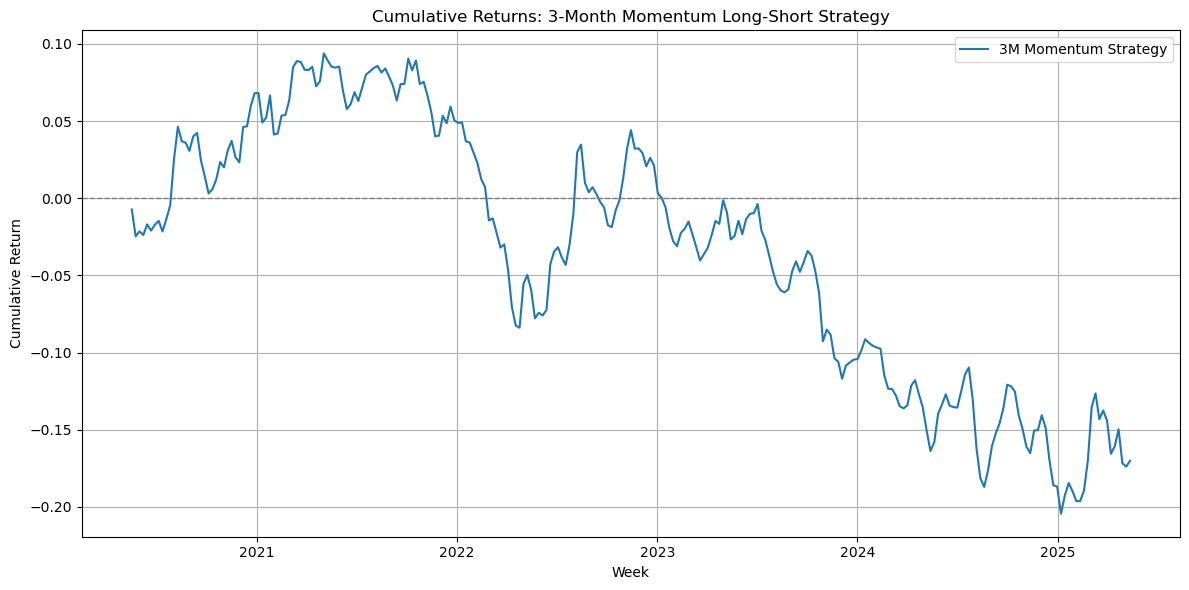

In [15]:
import matplotlib.pyplot as plt

# Initialize position column, as well as assigning top and bottom quintiles to +/- 1
# Maps top quantile --> 1, bottom quantile --> 1, keeps middle quantiles at zero by initialization
week['position'] = 0
week.loc[OHLCV['rank_3m'] == 4, 'position'] = 1
week.loc[OHLCV['rank_3m'] == 0, 'position'] = -1

# Assigning positive and negative weights to stocks that are longed and shorted, respectively
weights = week.groupby(['week', 'position']).symbol.count().unstack().fillna(0)
weights = weights.apply(lambda x: 1 / x if x.name in [1, -1] else 0, axis=0)

# Mapping new weights to each row
week['weight'] = week.apply(lambda row:
    weights.loc[row['week'], row['position']] if row['position'] != 0 else 0, axis=1)

# Weekly contribution of each stock to portfolio 
week['pnl'] = week['weight'] * week['Next Week Returns']

# Total portfolio return
portfolio = week.groupby('week')['pnl'].sum()

# Turnover (aggregate change in positions), Transaction cost (using 50 bps), Net return computations
positions = week.pivot(index='week', columns='symbol', values='position').fillna(0)
turnover = positions.diff().abs().sum(axis=1).shift(-1)
costs = 0.005 * turnover
portfolio_net = portfolio - costs

# Cumulative Return Computation
cumulative = (1 + portfolio_net).cumprod()

# Sharpe Ratio Computation
mean_return = portfolio_net.mean()
std_return = portfolio_net.std()
sharpe = (mean_return / std_return) * np.sqrt(52)

# Max Drawdown Computation 
roll_max = cumulative.cummax()
drawdown = cumulative / roll_max - 1
max_dd = drawdown.min()

rolling_sharpe = portfolio_net.rolling(52).mean() / portfolio_net.rolling(52).std() * np.sqrt(52)

# Visualization using Matplotlib library
cumulative_returns = portfolio_returns_3m.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='3M Momentum Strategy')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Cumulative Returns: 3-Month Momentum Long-Short Strategy')
plt.xlabel('Week')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Implications

After applying a Long-Short Portfolio for a 3-Month Momentum Signal, we make the following observations:
1.  Our portfolio has a slightly positive mean return in 2020-2021, implying that the 3-month momentum signal was working.
2.  Early-Mid 2022 experiences a significant recession in mean return$-$the momentum signal underperforms greatly here.
3.  There is a small rebound near the end of 2022.
4.  Negative returns are quite consistent after 2022, reaffirming that the momentum signal was not effective and has negative predictive power.
5.  Although there are some instances of rebounding, they are short-lived and the stock price drops shortly after. Here, volatility does not imply risk, for there is a consistent downward trend.
6.  The Sharpe Ratio is almost always below zero, suggesting that our portfolio is losing money. It is constantly fluctuating, which is representative of an unstable portfolio.

There are some potential interpretations for why momentum signaling is failing:
1.  The momentum signal is negatively correlated with returns in the market.
2.  Drastic and instantaneous changes in the market may balance or reverse the direction of initial positive momentum.
3.  The model may be too flexible and overfitting the behavior of stock prices by trying to capture excessive noise and outliers.

### Conclusion -- Task 2

I chose the 3-month momentum factor for this task because not only is it a widely renowned signal, but I wanted to see a more detailed performance of our hedging portfolio would perform by longing positive-returning assets (top quantile) and shorting underperforming ones (bottom quantile), despite observing negative mean returns for both signal methods in **Task 1.** This ensures we remain market-neutral, follow a 50 bps transaction cost, all while adjusting for risk. The very underwhelming performance, as reflected by the rolling Sharpe Ratio consistenly going below zero, is what surprised me the most. Following Task 1, I was expecting a shallower decline in return and now realize that the factor signal is not effective in the given period. With more time, I would have liked to once again construct a compromised strategy that combines reversal and momentum signals. Additionally, I think it would be interesting to perform specific analysis on different periods, namely in separate bull and bear portfolios.

## Task 3: Analyst Price Targets and KPIs

Goal: Generate 5-10 insightful Key Performance Indicators (KPIs) to analyze and interpret analyst price targets within the context of actual stock performance.

In [30]:
target = pd.read_sql_query(f"SELECT * FROM {'price_target_news'}", con)

Below are 5 KPIs that will be used to analyze potential stock performance:

1.  Standard Deviation of Target Premiums
2.  Average and Median of Target Premiums
3.  Signal Strength
4.  Distribution of Targets (Bearish vs. Bullish)
5.  Target Reversion Risk

A *target premium* is the percentage difference between an analyst's price target and the stock's market price at an issued time, and serves as a basis for KPI computations. If $\tau$ is the target premium, $\hat{P}$ is the target price, and $P$ is the issued price, then
$$\tau_i = 100 \times \frac{\hat{P}_i - P_i}{P_i}.$$

#### Standard Deviation of Target Premiums
Let $\overline{\tau}, 1 \leq i \leq N$ be the mean target return. The standard deviation of target premiums is then
$$\sigma_{\tau} = \sqrt{\frac{1}{N} \sum_{i = 1}^N \left(\tau - \overline{\tau} \right)^2}$$
where $i$ is indexed over each analyst call. This KPI captures the spread, or divergence of calls. A larger $\sigma_{\tau}$ implies more uncertainty over stock valuations. 

#### Average and Median of Target Premiums

Average - Offers the overall concensus/sentiment of analyst forecasts.

Median - More adjusted for potential outliers and displays the "central tendency" of forecasts.

#### Signal Strength

As the KPI implies, signal strength measures the strength of an analyst's call is compared to the mean. Statistically, signal strength is the *z-score* of a set of target premiums.

$$\overrightarrow{z} = \frac{\overrightarrow{\tau} - \overline{\tau}}{\sigma_{\tau}}.$$

A strong signal strength is more likely to draw attention and should be often treated with skepticism. 
Any $z_i < 0$ indicates a bearish signal and $z_i > 0$ indicates a bullish signal. Typically, if $|z_i| \geq 2$, then we consider these outliers.

#### Distribution of Targets

The distribution of bearish and bullish signals are given by how many analyst calls have a negative or positive target premium, respectively. These ratios show the overall sentiment of analysts. For instance, a highly bullish market could imply optimism about the future stock market.

#### Target Reversion Risk
Tarket Reversion Risk is a measure of how many targets are close to the current price, indicating the ratio of analysts who believe the stock will revert. While the threshold is arbitrary, we will count the number of calls in which $|\tau| < 2$.

$$RR = 100 \times \frac{\text{number of times } \lbrace i: |\tau_i| < 2 \rbrace}{N}$$

From this, we learn how much analysts expect bearish forecasts.  

In [29]:
target['exp_return'] = (
    (target['adj_price_target'] - target['price_when_posted']) /
    target['price_when_posted']
) * 100

# Standard Deviation of Target Premiums
std_premium = target['exp_return'].std()

# Average and Median of Target Premiums
avg_premium = target['exp_return'].mean()
median_premium = target['exp_return'].median()

# Signal Strength
target['signal_strength'] = (target['exp_return'] - avg_premium) / std_premium

# Distribution of Targets
target['bias'] = np.where(target['exp_return'] > 0, 'Bullish', 'Bearish')
distributions = target['bias'].value_counts(normalize=True) * 100

# Target Reversion Risk
target['reversion_risk'] = target['exp_return'].abs() < 2
trr = target['reversion_risk'].mean() * 100

print(f"Average Target Premium: {avg_premium:.2f}%")
print(f"Median Target Premium: {median_premium:.2f}%")
print(f"Standard Deviation of Premiums: {std_premium:.2f}%")
print(target['signal_strength'].head(5))
print(f"Bullish vs Bearish:\n{distributions}")
print(f"Target Reversion Rate: {trr:.2f}%")

Average Target Premium: 17.81%
Median Target Premium: 14.73%
Standard Deviation of Premiums: 56.62%
0   -0.037322
1   -0.305395
2   -0.054496
3   -0.355969
4   -0.226142
Name: signal_strength, dtype: float64
Bullish vs Bearish:
Bullish    88.346449
Bearish    11.653551
Name: bias, dtype: float64
Target Reversion Rate: 5.48%


### Interpretation
1.  On average, analysts expect stock prices to rise by 17.81% relative to when the forecast was issued. The median target premium (14.73\%) indicates some right-hand skewness.
2.  There is great variability in forecast optimism, implying a lot of uncertainty in the future stock market.
3.  (Not indicative of entire dataset) Each signal strength is negative, with some of decent magnitude. This implies decent bearish expectations for the current market (i.e. 30.5% downside for the second entry).
4.  Nearly 9 out of 10 analysts believe the stock price will increase.
5.  Only 5.48% of targets actually fall below the current stock price when the forecast was issued. This reinforces the previous observation of optimism bias and that bearish calls are less likely.

### Conclusions -- Task 3
I chose these Key Performance Indicators because they provide more meaningful conclusions than just accuracy alone. By introducing analyst sentiment, signal quality, and openness to bias, reversion rate, we explore and distinguish different forecasts and understand how we perceive the market. What surprised me about these results was the interactions between (1): the given signal strength, (2) variability, and (3) optimism bias. The top 5 signal strengths (not in order) would imply a bearish sentiment, but almost 90% of analysts expect the stock price to increase. Given that the variability is quite large, it would make sense for there to be more bearish expectations unless the mean is well deep into a positive premium return. With more time, I would have liked to see overall forecast performance through time series analysis (to see if stocks actually meet their intended target).

*Unfortunately, due to time constraints, I was unable to write up a small abstract at the top.*